# Import Libraries

In [13]:
# Data Manipulation
import pandas as pd
import numpy as np

# Plotting/EDA
import matplotlib.pyplot as plt
import seaborn as sns

# File paths
from pathlib import Path

# General CPU Usage Optimization
import os
os.environ['OMP_NUM_THREADS'] = '16'
os.environ['MKL_NUM_THREADS'] = '16'
os.environ['OPENBLAS_NUM_THREADS'] = '16'
os.environ['NUMEXPR_NUM_THREADS'] = '16'

# Molecular features
import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect
from rdkit.Chem import rdFingerprintGenerator
import numpy as np
import pandas as pd

# # Machine Learning - Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

# Machine Learning - Model
import xgboost as xgb

# Machine Learning - Hyperparameter Optimization
import optuna

# Machine Learning - Model Evaluation
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Model Saving
import pickle

# Progress bars
tqdm_notebook_available = False
try:
    from tqdm.notebook import tqdm
    tqdm.pandas() # Enable tqdm for pandas apply
    tqdm_notebook_available = True
except ImportError:
    print("tqdm.notebook not found.")

# Load Cleaned Data

In [6]:
data_filepath = Path("../data/processed/gi50_final_cleaned_data.csv")

try:
    df = pd.read_csv(data_filepath)
    print(f"Successfully loaded data from: {data_filepath}")
    print(f"Shape of loaded data: {df.shape}")
    display(df.head())
    display(df.info())
except FileNotFoundError:
    print(f"Error: Data file not found at {data_filepath}. Please ensure '00_Build_Clean_Dataset.ipynb' was run and saved the file.")

Successfully loaded data from: ..\data\processed\gi50_final_cleaned_data.csv
Shape of loaded data: (18964, 5)


,molregno,canonical_smiles,molfile,pGI50,num_activities
0,148,O=c1oc2c(O)c(O)cc3c(=O)oc4c(O)c(O)cc1c4c23,\n RDKit 2D\n\n 22 25 0 0 0 0...,7.999957,1
1,666,Cc1c(C)c2c(c(C)c1O)CCC(C)(COc1ccc(CC3SC(=O)NC3...,\n RDKit 2D\n\n 31 34 0 0 0 0...,4.823909,1
2,696,Cc1cc(O)nc2c3c(ccc12)OC(C)(C)C=C3,\n RDKit 2D\n\n 18 20 0 0 0 0...,5.421428,7
3,717,CC(O)(CS(=O)(=O)c1ccc(F)cc1)C(=O)Nc1ccc(C#N)c(...,\n RDKit 2D\n\n 29 30 0 0 0 0...,5.583359,1
4,846,CC1(C)CC(C)(C)c2cc(NC(=S)Nc3ccc([N+](=O)[O-])c...,"Thiourea, N-(3,4-dihydro-2,2,4,4-tetramethyl-2...",5.405822,9


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18964 entries, 0 to 18963
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   molregno          18964 non-null  int64  
 1   canonical_smiles  18964 non-null  object 
 2   molfile           18964 non-null  object 
 3   pGI50             18964 non-null  float64
 4   num_activities    18964 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 740.9+ KB


None

# EDA

## Initial Checks

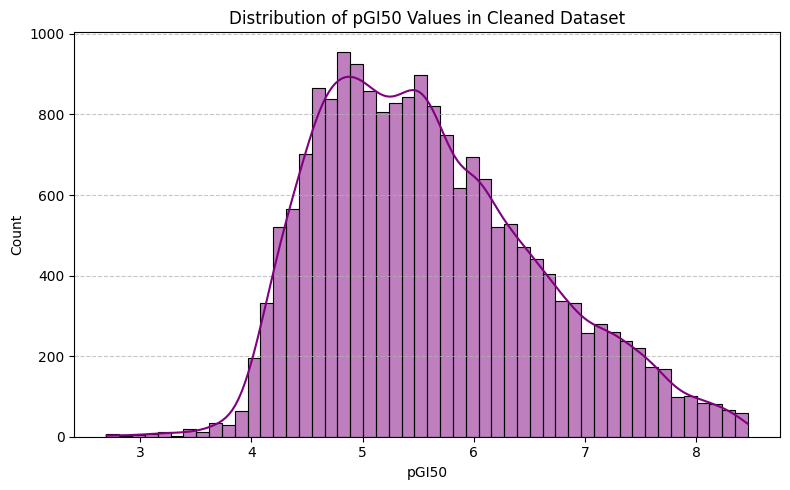


Descriptive statistics of numerical columns:


,molregno,pGI50,num_activities
count,1.896400e+04,18964.000000,18964.000000
mean,1.469810e+06,5.605709,5.678232
std,8.725293e+05,0.988554,11.122305
min,1.480000e+02,2.699000,1.000000
25%,5.755018e+05,4.835585,1.000000
50%,1.557706e+06,5.470846,2.000000
75%,2.281521e+06,6.236571,5.000000
max,2.881183e+06,8.462476,219.000000



Remaining missing values:


Series([], dtype: int64)


Distribution of 'num_activities':


num_activities
1    0.330363
2    0.176756
3    0.147437
4    0.082894
5    0.052731
Name: proportion, dtype: float64

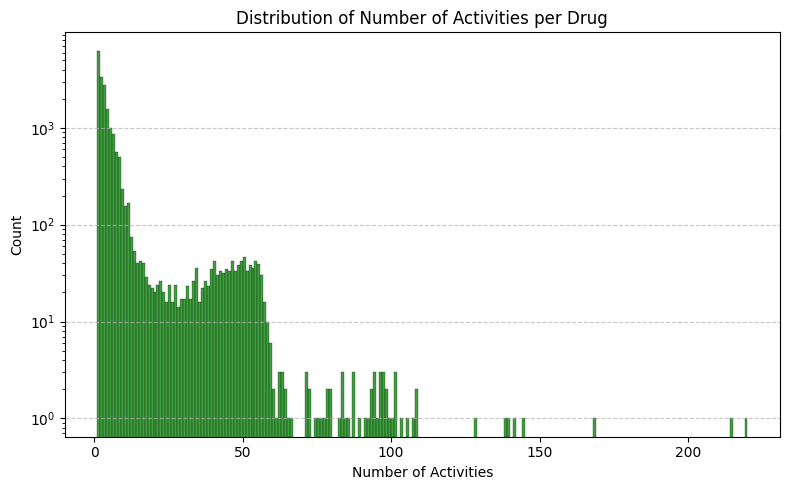

In [7]:
# Re-confirm target variable distribution (pGI50)
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='pGI50', bins=50, kde=True, color='purple')
plt.title('Distribution of pGI50 Values in Cleaned Dataset')
plt.xlabel('pGI50')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Check summary statistics for numerical columns, especially pGI50
print("\nDescriptive statistics of numerical columns:")
display(df.describe())

# Check for any remaining missing value (should be minimal or none)
print("\nRemaining missing values:")
display(df.isnull().sum()[df.isnull().sum() > 0])

# Check num_activities distribution
if 'num_activities' in df.columns:
    print("\nDistribution of 'num_activities':")
    display(df['num_activities'].value_counts(normalize=True).head())

    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x='num_activities', bins=range(1, df['num_activities'].max() + 2), kde=False, color='green')
    plt.title('Distribution of Number of Activities per Drug')
    plt.xlabel('Number of Activities')
    plt.ylabel('Count')
    plt.yscale('log') # Often useful if few drugs have many activities
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Engineer Features

## Generate RDKit Descriptors (Physicochemical properties, counts, etc.)

In [14]:
print("Starting molecular feature generation from SMILES...")

def generate_all_rdkit_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        # Return a list of NaNs for all descriptors if SMILES is invalid
        return [np.nan] * len(Descriptors._descList)
    else:
        # Descriptors._descList contains (name, function) tuples
        return [descriptor[1](mol) for descriptor in Descriptors._descList]

# Get the list of all RDKit descriptor names
all_rdkit_descriptor_names = [descriptor[0] for descriptor in Descriptors._descList]

print(f"Generating {len(all_rdkit_descriptor_names)} RDKit physicochemical descriptors...")
if tqdm_notebook_available:
    rdkit_desc_values = df['canonical_smiles'].progress_apply(generate_all_rdkit_descriptors)
else:
    rdkit_desc_values = df['canonical_smiles'].apply(generate_all_rdkit_descriptors)

# Convert the list of lists into a DataFrame
rdkit_desc_df = pd.DataFrame(rdkit_desc_values.tolist(), columns=all_rdkit_descriptor_names, index=df.index)
print("RDKit physicochemical descriptors generated.")
display(rdkit_desc_df.head())

Starting molecular feature generation from SMILES...
Generating 217 RDKit physicochemical descriptors...


  0%|          | 0/18964 [00:00<?, ?it/s]

[18:22:54] Explicit valence for atom # 34 P, 7, is greater than permitted


RDKit physicochemical descriptors generated.


,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,11.996238,11.996238,0.005972,-0.940881,0.216285,11.818182,302.194,296.146,302.006267,110.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11.735952,11.735952,0.229569,-0.467042,0.716604,22.645161,441.549,414.333,441.160994,164.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9.639307,9.639307,0.047809,-0.299061,0.767926,16.388889,241.290,226.170,241.110279,92.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13.006084,13.006084,0.342865,-4.860872,0.560412,13.965517,430.379,416.267,430.061041,154.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10.730998,10.730998,0.052565,-0.422109,0.375924,16.888889,401.557,378.373,401.123169,142.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Generate Morgan Fingerprints

In [15]:
fingerprint_radius = 2 # Common choice: 2 or 3
fingerprint_nBits = 2048 # Common choice: 1024 or 2048

morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=fingerprint_radius, fpSize=fingerprint_nBits)

def generate_morgan_fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        # Return a list of zeros for the fingerprint if SMILES is invalid
        return [0] * fingerprint_nBits
    else:
        fp = morgan_gen.GetFingerprint(mol)
        return list(fp) # Convert ExplicitBitVect to a list of integers

print(f"\nGenerating Morgan Fingerprints (Radius={fingerprint_radius}, nBits={fingerprint_nBits})...")
if tqdm_notebook_available:
    morgan_fp_values = df['canonical_smiles'].progress_apply(generate_morgan_fp)
else:
    morgan_fp_values = df['canonical_smiles'].apply(generate_morgan_fp)

# Convert the list of lists into a DataFrame
morgan_fp_df = pd.DataFrame(morgan_fp_values.tolist(),
                            columns=[f'morgan_fp_{i}' for i in range(fingerprint_nBits)],
                            index=df.index)
print("Morgan Fingerprints generated.")
display(morgan_fp_df.head())


Generating Morgan Fingerprints (Radius=2, nBits=2048)...


  0%|          | 0/18964 [00:00<?, ?it/s]

[18:30:09] Explicit valence for atom # 34 P, 7, is greater than permitted


Morgan Fingerprints generated.


,morgan_fp_0,morgan_fp_1,morgan_fp_2,morgan_fp_3,morgan_fp_4,morgan_fp_5,morgan_fp_6,morgan_fp_7,morgan_fp_8,morgan_fp_9,...,morgan_fp_2038,morgan_fp_2039,morgan_fp_2040,morgan_fp_2041,morgan_fp_2042,morgan_fp_2043,morgan_fp_2044,morgan_fp_2045,morgan_fp_2046,morgan_fp_2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Combine Features And Save Dataset

In [20]:
features_df = df[['molregno', 'pGI50', 'canonical_smiles']].copy() # Keep SMILES for reference

# Conditionally add 'num_activities' if it exists in the original df
if 'num_activities' in df.columns:
    features_df['num_activities'] = df['num_activities']

# Concatenate the generated RDKit descriptors and Morgan fingerprints
features_df = pd.concat([features_df, rdkit_desc_df, morgan_fp_df], axis=1)

# Handle any NaN values generated
initial_rows_before_feature_dropna = features_df.shape[0]
features_df.dropna(inplace=True)
rows_after_feature_dropna = features_df.shape[0]

if initial_rows_before_feature_dropna != rows_after_feature_dropna:
    rows_removed_due_to_nan = initial_rows_before_feature_dropna - rows_after_feature_dropna
    print(f"\nWarning: Dropped {rows_removed_due_to_nan} rows due to NaN values in generated features (e.g., from invalid SMILES).")
    print(f"New DataFrame shape after feature NaN drop: {features_df.shape}")



New DataFrame shape after feature NaN drop: (18743, 2269)


## Refine Features (*)

**NOTE**: This section is ITERATIVE and is run as needed based on outputs in other files such as model-specific notebooks.

### Visualize Feature Distributions

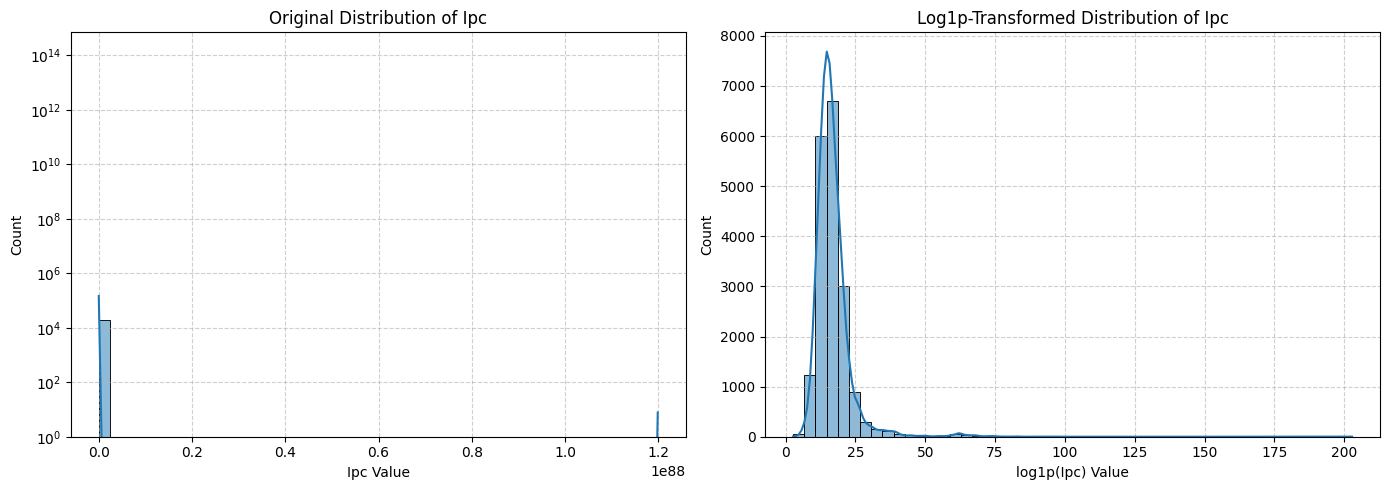


--- Descriptive Statistics for Ipc (Original Values) ---


count    1.874300e+04
mean     6.396526e+83
std      8.757169e+85
min      1.360964e+01
1%       3.065675e+03
10%      8.281945e+04
25%      6.204611e+05
50%      6.775744e+06
75%      1.353448e+08
90%      4.963041e+09
99%      4.085466e+19
99.9%    1.142365e+32
max      1.198901e+88
Name: Ipc, dtype: float64


--- Data points with highest Ipc values ---


3422     1.198901e+88
4191     1.586424e+44
4117     6.761484e+41
4185     3.223169e+41
5070     6.701014e+40
3421     1.805888e+40
4184     8.338991e+37
4170     1.922392e+36
5071     9.928989e+35
15884    3.690800e+35
Name: Ipc, dtype: float64


--- Skewness of Ipc (Original Values ---
136.90507660419317

--- Skewness of Ipc (Log1p-Scaled Values ---
4.868875233071964


In [22]:
plt.figure(figsize=(14, 5))

# Subplot 1: Original 'Ipc' distribution (may be heavily skewed)
plt.subplot(1, 2, 1)
sns.histplot(features_df['Ipc'], bins=50, kde=True)
plt.title('Original Distribution of Ipc')
plt.xlabel('Ipc Value')
plt.ylabel('Count')
plt.grid(True, linestyle='--', alpha=0.6)
plt.yscale('log')
plt.ylim(bottom=1) # Ensure y-axis starts at 1 for log scale

# Subplot 2: Log-transformed 'Ipc' distribution
plt.subplot(1, 2, 2)
# Filter out any non-positive values if log1p is still problematic (Ipc should be non-negative)
sns.histplot(np.log1p(features_df['Ipc']), bins=50, kde=True)
plt.title('Log1p-Transformed Distribution of Ipc')
plt.xlabel('log1p(Ipc) Value')
plt.ylabel('Count')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

print("\n--- Descriptive Statistics for Ipc (Original Values) ---")
display(features_df['Ipc'].describe(percentiles=[.01, .1, .25, .5, .75, .9, .99, .999]))

print("\n--- Data points with highest Ipc values ---")
display(features_df['Ipc'].nlargest(10)) # Show top 10 largest values

print(f"\n--- Skewness of Ipc (Original Values ---\n{features_df['Ipc'].skew()}")

log_scaled_ipc = np.log1p(features_df['Ipc'])
print(f"\n--- Skewness of Ipc (Log1p-Scaled Values ---\n{log_scaled_ipc.skew()}")

### Handle Feature-Specific Issues

In [23]:
IPC_CAP_VALUE = 1e15

print(f"Checking 'Ipc' feature for values exceeding cap of {IPC_CAP_VALUE:.0e}...")

original_max_ipc = features_df['Ipc'].max()
num_values_to_cap = (features_df['Ipc'] > IPC_CAP_VALUE).sum()

print(f"Original max 'Ipc' value: {original_max_ipc:.2e}")

if num_values_to_cap > 0:
    print(f"WARNING: Found {num_values_to_cap} 'Ipc' values to cap.")
    # Apply the capping using .clip() method
    features_df['Ipc'] = features_df['Ipc'].clip(upper=IPC_CAP_VALUE)
    print(f"Max 'Ipc' value after capping: {features_df['Ipc'].max():.2e}")
else:
    print("No 'Ipc' values found exceeding the cap. No capping applied.")

Checking 'Ipc' feature for values exceeding cap of 1e+15...
Original max 'Ipc' value: 1.20e+88
Max 'Ipc' value after capping: 1.00e+15


### Check for any NaNs generated

In [24]:
initial_rows_before_feature_dropna = features_df.shape[0]
features_df.dropna(inplace=True)
rows_after_feature_dropna = features_df.shape[0]

if initial_rows_before_feature_dropna != rows_after_feature_dropna:
    rows_removed_due_to_nan = initial_rows_before_feature_dropna - rows_after_feature_dropna
    print(f"\nWarning: Dropped {rows_removed_due_to_nan} rows due to NaN values in generated features (e.g., from invalid SMILES).")
    print(f"New DataFrame shape after feature NaN drop: {features_df.shape}")

# Save the dataset

In [25]:
# Save this feature engineered dataset
features_dir = Path("../data/features")
features_dir.mkdir(parents=True, exist_ok=True)

print(f"\nSaving fully feature-engineered DataFrame to {features_dir}...")
features_df.to_parquet(features_dir / "gi50_features.parquet", index=False)
print("Fully feature-engineered DataFrame saved successfully.")

print("\nFeature engineering complete.")


Saving fully feature-engineered DataFrame to ..\data\features...
Fully feature-engineered DataFrame saved successfully.

Feature engineering complete.
